# **Prediction of Volumes**

## **Importing modules**

In [ ]:
import os
import pathlib
import cv2
import glob
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import concatenate
#from tf_keras_vis.saliency import Saliency
#from tf_keras_vis.utils import normalize
#from tf_keras_vis.gradcam import Gradcam
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Run this cell for more readable visuals 
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.style.use('seaborn-whitegrid')
plt.rcParams.update(params)
%matplotlib inline

**The model takes long to train, so the weights are in this folder: https://drive.google.com/drive/folders/1Cxf1xZWPUb37uM_JBHIFI7zW5bmxM0vn?usp=sharing </br>
The weights are also in the drive link that we have shared.**

## **IMPORTANT**</BR>
**In case of using the saved weights, just comment the ".fit" part of the code. And uncomment the load_weights part.**

## **Loading the data and Preprocessing**

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_images_from_folder(folder):
    num_of_images = 0
    for filename in glob.glob(folder):
        #print(filename)
        idx= filename.find("synth_")
        part_type = filename[idx+6:idx+9]
        length = float(filename[idx+11:idx+14])
        width = float(filename[idx+16:idx+19])
        height= float(filename[idx+21:idx+24])
        partx = float(filename[idx+26:idx+31])
        party = float(filename[idx+33:idx+38])
        partz = float(filename[idx+40:idx+45])
        ang1  = float(filename[idx+47:idx+50])
        ang2  = float(filename[idx+52:idx+55])
        ang3  = float(filename[idx+57:idx+60])
        cam1= float(filename[idx+64:idx+68])
        cam2= float(filename[idx+72:idx+76])
        cam3= float(filename[idx+80:idx+84])
        cam4= float(filename[idx+88:idx+92])

        if part_type=="cyl":
            volume = 3.1415 * length * (width/2.0)**2
            y_one_hot = np.array([[1, 0, 0]])
        if part_type=="cub":
          volume = length * width * height
          y_one_hot = np.array([[0, 1, 0]])
        if part_type == "sph":
          volume = (4.0/3.0) * 3.1415 * (length / 2.0)**3
          y_one_hot = np.array([[0, 0, 1]])

        # print(part_type)
        # print(length, width, height, volume)
        # print(partx, party, partz)
        # print(ang1, ang2, ang3)
        # print(cam1, cam2, cam3, cam4)

#       print(filename)
        image = cv2.imread(filename)
#       cv2.imshow('Original image', image)
#       print(image[10,10])
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       print(gray[10,10])
#       cv2.imshow('Gray image', gray)

        if gray is not None:
            num_of_images += 1
            gray_r = gray.reshape(1, gray.shape[0], gray.shape[1], 1)

            if num_of_images == 1:
                sizex = gray.shape[0]
                sizey = gray.shape[1]
                x_image = gray_r.copy()
                x_numeric = np.array([[cam1, cam2, cam3, cam4]])
                y_shape = y_one_hot.copy()
                y_size = np.array([[length, width, height, ang1, ang2, ang3, volume]])
            else:
                if (gray.shape[0] == sizex) and (gray.shape[1] == sizey):
                    x_image = np.append(x_image, gray_r, axis=0)
                    x_numeric = np.append(x_numeric, np.array([[cam1, cam2, cam3, cam4]]), axis=0)
                    y_shape = np.append(y_shape, y_one_hot, axis=0)
                    y_size = np.append(y_size,
                                       np.array([[length, width, height, ang1, ang2, ang3, volume]]), axis=0)
                else:
                    print(sizex, gray.shape[0])
                    print(sizey, gray.shape[1])
                    print('Image number', num_of_images, ' : Size mis-match')
                    exit()
        #print("Shape of x :", x.shape, end='\n         ')
        #print("Shape of y :", y.shape, end='\n         ')
        #print(str(num_of_images)+' '+filename+' '+str(gray.shape))

    print("Data read from ", str(folder), end='\n      ')
    print("Total number of images read =", x_image.shape[0], end='\n      ')
    print("Pixels in each image =", sizex, ' * ', sizey, end='\n      ')
    print("Total number of pixels", sizex * sizey, end='\n         ')

    return x_image, x_numeric, y_shape, y_size, sizex, sizey

In [ ]:
def create_data_sets():
    #read synthetic data set
    dirname_regression_data = "/content/drive/MyDrive/project-2/synthetic_shape_data_all-20211208T180010Z-001/"
    dirname = os.listdir(dirname_regression_data)

    print("Number of directories :", len(dirname),"\n")

    num_of_dir = 0
    for dir in dirname:
        num_of_dir += 1
        folder_name = str(dirname_regression_data)+str(dir)+str('/*.png')

        #print(folder_name)

        (x_image, x_numeric, y_shape, y_size, sizex, sizey) = load_images_from_folder(folder_name)

        x_set = x_image.copy()
        x_num = x_numeric.copy()
        y_set = y_size.copy()

        if num_of_dir == 1:
            print("Creating first dataset\n")
            x = x_set.copy()
            x_n = x_num.copy()
            y = y_set.copy()
        else:
            print("Appending datasets\n")
            x = np.append(x, x_set, axis=0)
            x_n = np.append(x_n,x_num, axis=0 )
            y = np.append(y, y_set, axis=0)

    #rand_pic=np.random.randint(0,m)
    #arr=x[rand_pic,:].reshape(sizex, sizey)
    #im = Image.fromarray(arr)
#    im.show()

    #arr = x[rand_pic, 0:num_pix//2].reshape(sizex//2, sizey)
    #im = Image.fromarray(arr)
#    im.show()

    #arr1 = arr[:,0:sizey//2]
    #im = Image.fromarray(arr1)
#    im.show()

    return x,x_n, y, sizex, sizey

In [ ]:
x,x_n,y,size_x,size_y=create_data_sets()

Number of directories : 65 

Data read from  /content/drive/MyDrive/project-2/synthetic_shape_data_all-20211208T180010Z-001/sph_D032/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Creating first dataset

Data read from  /content/drive/MyDrive/project-2/synthetic_shape_data_all-20211208T180010Z-001/sph_D045/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/project-2/synthetic_shape_data_all-20211208T180010Z-001/sph_D038/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/project-2/synthetic_shape_data_all-20211208T180010Z-001/sph_D028/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total

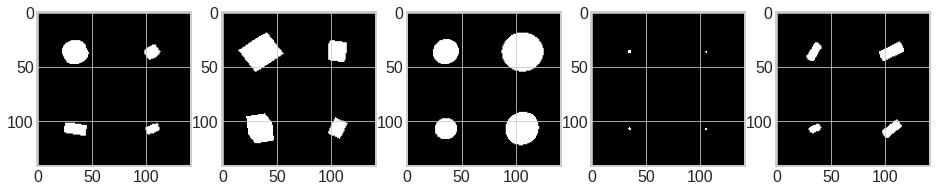

In [ ]:
fig, ax = plt.subplots(1,5,figsize = (16,6))
a = random.sample(range(x_n.shape[0]), 5)
cnt = 0
for i in a:
  ax[cnt].imshow(x[i].reshape((142,142)),cmap="gray")
  cnt+=1

In [ ]:
# columns where distances are stored
x_n.shape

(6438, 4)

In [ ]:
y.shape

(6438, 7)

In [ ]:
# selecting only the volumes, bcoz that's only required for this part
y_fh = y[:,-1]
y_fh

array([17156.77866667, 17156.77866667, 17156.77866667, ...,
         125.        ,   125.        ,   125.        ])

In [ ]:
y_fh.shape

(6438,)

In [ ]:
# images
x.shape

(6438, 142, 142, 1)

## **Splitting into train, validation and test datasets**

**We had to take a random state because, we wanted to take both images and distances as inputs. So, they both should be from the same image, so to deal with it, we kept the random state. On changing the random states, the results varied by a very small amount.**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y_fh,test_size=0.2, random_state=111)
x_ntrain,x_ntest,y_ntrain,y_ntest=train_test_split(x_n,y_fh,test_size=0.2, random_state=111)

## **Preprocessing the images for putting them into the model**

In [ ]:
# scale pixels
#no y and modify
def prep_pixels(x_train,x_test):
  # convert from integers to floats
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train_norm= x_train/255.0
  x_test_norm=x_test/255.0
	# return normalized images
  return x_train_norm,x_test_norm

In [ ]:
x_train_norm,x_test_norm=prep_pixels(x_train,x_test)

## **Creating the models**

### **Model-1 - Using only images as inputs**

**In this model, we have used a basic CNN model which takes only the images as input to predict the volumes. We have used Sequential API because the model was fairly simple.**

In [ ]:
# function to create a model
def define_model(filter):
  #defining the model based on filters
  model = Sequential()
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(142, 142, 1)))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
  model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.2))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
  model.add(Dense(filter, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
  model.add(Dense(1, activation='relu'))
	# compile model
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mse')
  print(model.summary())
  return model
 

In [ ]:
# creating a model with 64 filters in each layer
model=define_model(64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 142, 142, 64)      640       
                                                                 
 conv2d_35 (Conv2D)          (None, 142, 142, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 71, 71, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 71, 71, 64)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 conv2d_37 (Conv2D)          (None, 71, 71, 64)        36928     
                                                      

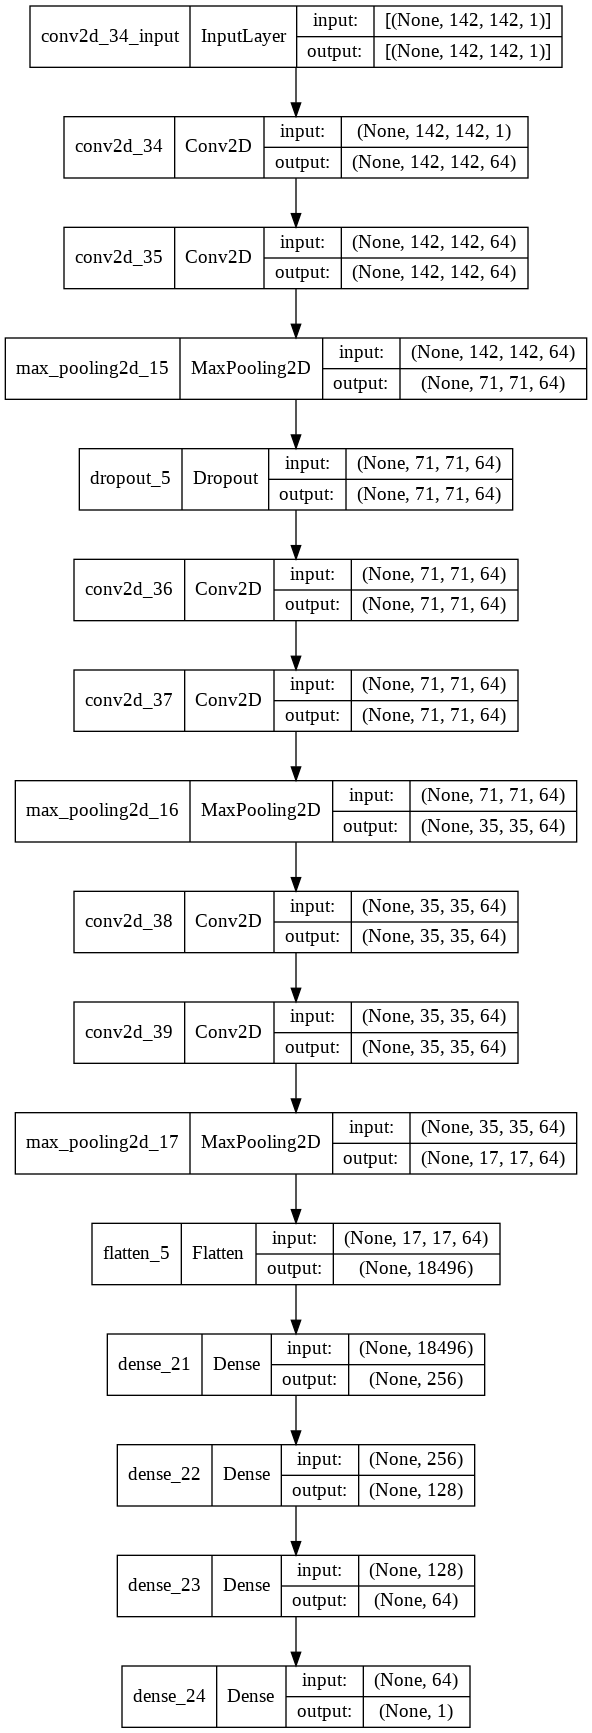

In [ ]:
# visualizing the model structure
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **fitting the model and evaluating**

In [ ]:
# defning the callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights= True,
)

In [ ]:
# fit model
model_1_history = model.fit(x_train_norm, y_train, epochs=50, batch_size=64, validation_data=(x_test_norm, y_test), verbose=1, callbacks = [callback])


Epoch 1/50
81/81 [==============================] - 35s 339ms/step - loss: 396412896.0000 - val_loss: 222995472.0000
Epoch 2/50
81/81 [==============================] - 25s 307ms/step - loss: 220333760.0000 - val_loss: 203858160.0000
Epoch 3/50
81/81 [==============================] - 25s 306ms/step - loss: 224072496.0000 - val_loss: 205493456.0000
Epoch 4/50
81/81 [==============================] - 25s 306ms/step - loss: 207289280.0000 - val_loss: 271514656.0000
Epoch 5/50
81/81 [==============================] - 25s 308ms/step - loss: 205523904.0000 - val_loss: 237727920.0000
Epoch 6/50
81/81 [==============================] - 25s 306ms/step - loss: 211353952.0000 - val_loss: 319714208.0000
Epoch 7/50
81/81 [==============================] - 25s 306ms/step - loss: 198522544.0000 - val_loss: 201089056.0000
Epoch 8/50
81/81 [==============================] - 26s 316ms/step - loss: 188484896.0000 - val_loss: 206901520.0000
Epoch 9/50
81/81 [==============================] - 25s 306ms/st

In [ ]:
model.save_weights('/content/drive/MyDrive/project-2/model_weights.npy')
# model.load_weights('/content/drive/MyDrive/project-2/model_weights.npy')

In [ ]:
y_pred = model.predict(x_test_norm)

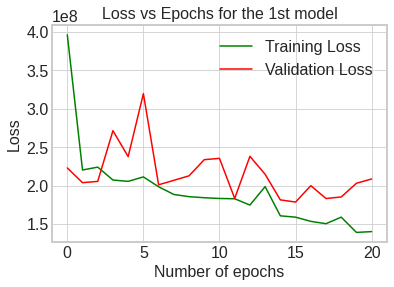

In [ ]:
plt.plot(model_1_history.history['loss'], color='g', label='Training Loss')
plt.plot(model_1_history.history['val_loss'], color='r', label='Validation Loss')
plt.title("Loss vs Epochs for the 1st model")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
from sklearn.metrics import r2_score
print("The R2 score for the 1st model is {:.2f}".format(r2_score(y_test, y_pred)))

The R2 score for the 1st model is 0.80


In [ ]:
y_pred.shape, y_test.shape

((1288, 1), (1288,))

In [ ]:
y_test = y_test.reshape(-1,1)

Text(0, 0.5, 'Actual Volumes(in cm^3)')

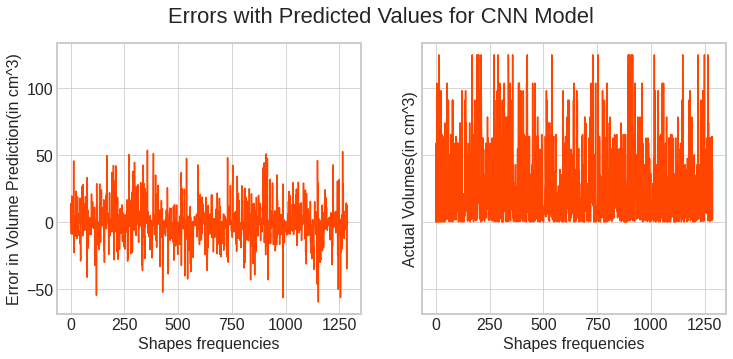

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5),sharey=True)
fig.suptitle('Errors with Predicted Values for CNN Model')
ax1.plot(y_test/1000-y_pred/1000,color='#FF4500')
ax1.set_xlabel("Shapes frequencies")
ax1.set_ylabel("Error in Volume Prediction(in cm^3)")

ax2.plot(y_test/1000,color='#FF4500')
ax2.set_xlabel("Shapes frequencies")
ax2.set_ylabel("Actual Volumes(in cm^3)")

### **Model-2 - Using both images and distances as inputs**

**It is a hybrid model which takes both the images and distances as input to predict the volumes. Functional API is used to create this model.**

**This model should perform much better than the previous one because it has the distance between the object and the camera included in inputs. We perceive the size of an object by the angle that it makes on our retina, and its solid angle helps to estimate its size. So, considering this, the distance was a very important predictor missing in our initial model. </br>**

**The solid angle will be calculated by the model because it will look through the features of the images. The images are very simple having only black and white pixels, so by estimating the number of white pixels, it would be very easy to predict the area that it is covering in the image (so, we can say that it gets the 2D-view very clearly and can predict the area by a high certainity now.)<br>**

**My guess is that the problem would come when the model won't categorise the shapes well (cubes, cylinders and spheres) within itself, so the predictions might have some errors.**

#### **creating the model and fitting it**

In [ ]:
# using functional API to take both the image, and the distances from the cameras as inputs.
# we'll concatenate them after the convolution layers.

# first part taking image as input
visible1 = Input(shape=(142,142,1))
conv11 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(visible1)
conv12 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv11)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv12)
conv13 = Conv2D(64, (3,3), activation='relu')(pool11)
drop11 = Dropout(0.2)(conv13)
conv14 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(drop11)
conv15 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv14)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv15)
conv16 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(pool12)
conv17 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv16)
pool13 = MaxPooling2D(pool_size=(2, 2))(conv17)
flat1 = Flatten()(pool13)

# second part taking the distances from the cameras as input
visible2 = Input(shape = (4))
dense21 = Dense(64, activation = 'relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(visible2)

# concatenating both outputs
merge = concatenate([flat1, dense21])

# making the dense layers with both these models
hidden1 = Dense(100, activation='relu')(merge)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(1)(hidden2)
model_concat = Model(inputs=[visible1, visible2], outputs=output)


In [ ]:
model_concat.compile(loss='mse', optimizer ="Adam")

In [ ]:
print(model_concat.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 142, 142, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 142, 142, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 142, 142, 64  36928       ['conv2d_40[0][0]']              
                                )                                                           

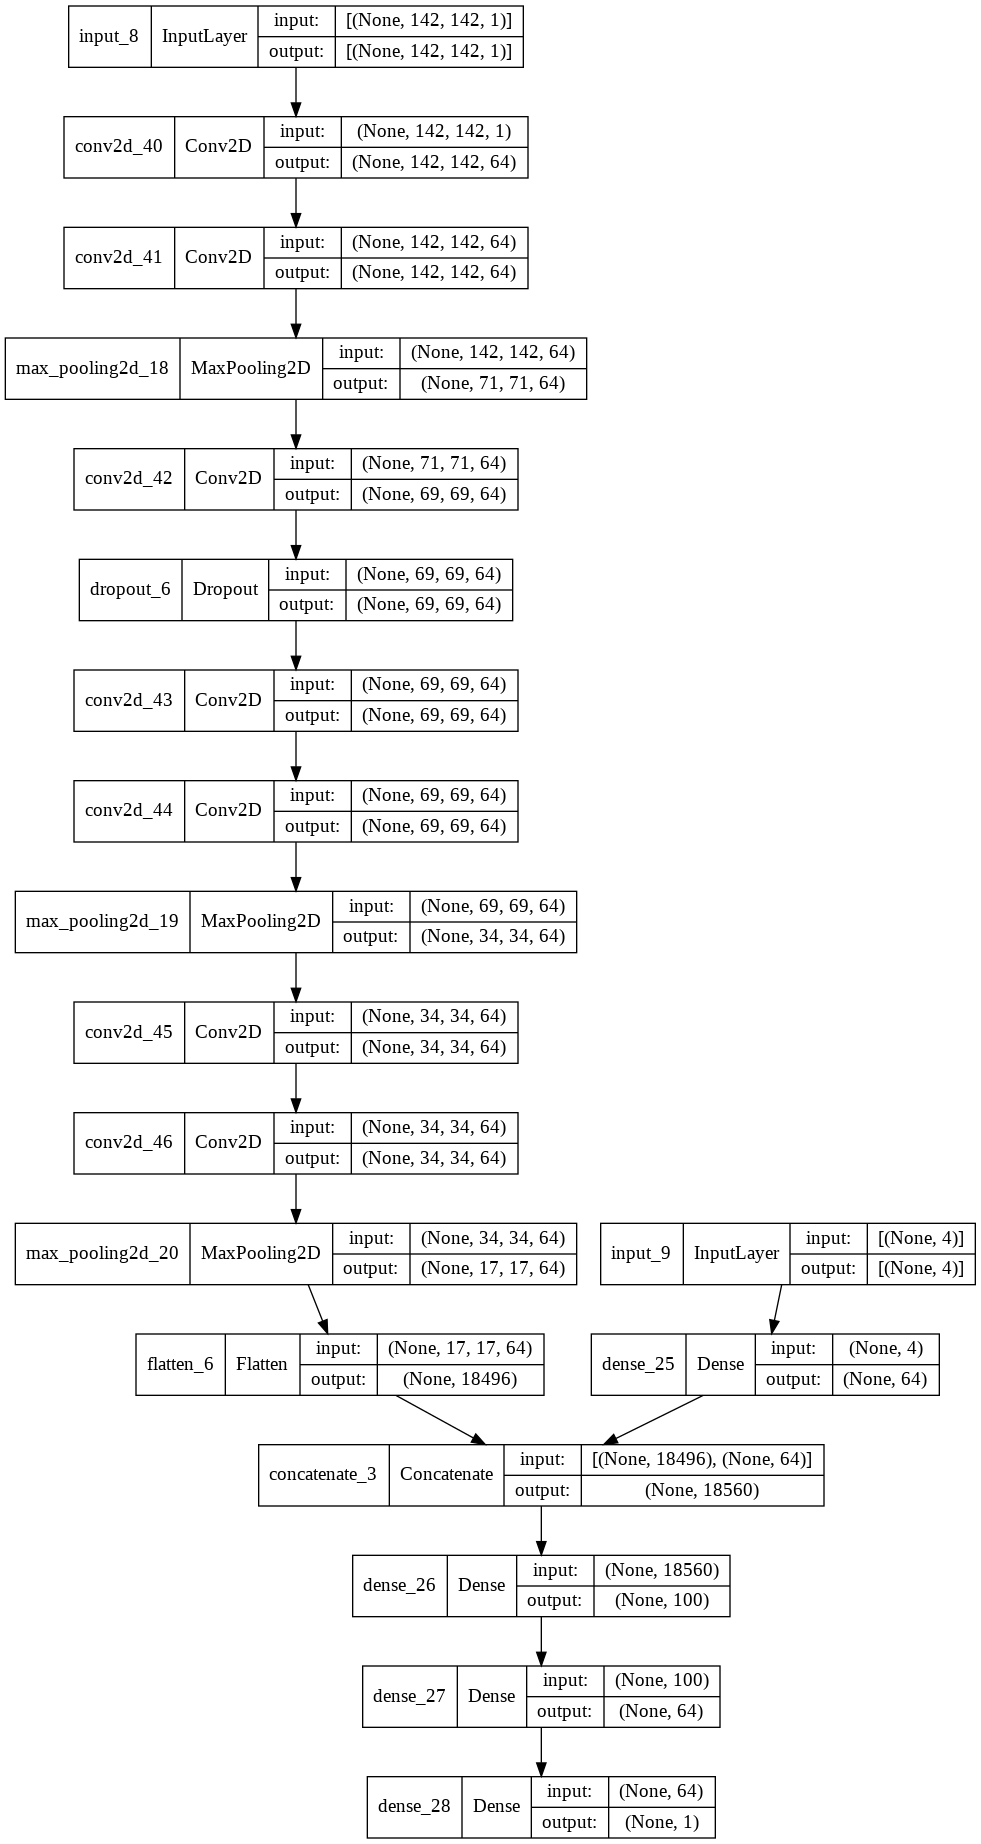

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_concat, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_2_history = model_concat.fit(x = [x_train_norm,x_ntrain],y = y_train, epochs=50, batch_size=64, validation_data=([x_test_norm, x_ntest], y_test), verbose=1, callbacks = [callback])

Epoch 1/50
81/81 [==============================] - 32s 357ms/step - loss: 390351008.0000 - val_loss: 220123856.0000
Epoch 2/50
81/81 [==============================] - 28s 340ms/step - loss: 214272336.0000 - val_loss: 185098960.0000
Epoch 3/50
81/81 [==============================] - 28s 340ms/step - loss: 188170848.0000 - val_loss: 178274544.0000
Epoch 4/50
81/81 [==============================] - 28s 340ms/step - loss: 167174896.0000 - val_loss: 126273320.0000
Epoch 5/50
81/81 [==============================] - 28s 340ms/step - loss: 107344048.0000 - val_loss: 84327904.0000
Epoch 6/50
81/81 [==============================] - 27s 340ms/step - loss: 64706856.0000 - val_loss: 82886424.0000
Epoch 7/50
81/81 [==============================] - 28s 340ms/step - loss: 46529748.0000 - val_loss: 52363400.0000
Epoch 8/50
81/81 [==============================] - 27s 340ms/step - loss: 35618500.0000 - val_loss: 52720848.0000
Epoch 9/50
81/81 [==============================] - 28s 341ms/step - lo

In [ ]:
model_concat.save_weights('/content/drive/MyDrive/project-2/model_concat_weights.npy')
# model_concat.load_weights('/content/drive/MyDrive/project-2/model_concat_weights.npy')

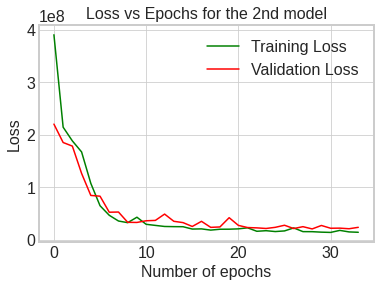

In [ ]:
plt.plot(model_2_history.history['loss'], color='g', label='Training Loss')
plt.plot(model_2_history.history['val_loss'], color='r', label='Validation Loss')
plt.title("Loss vs Epochs for the 2nd model")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
y_npred = model_concat.predict(x = [x_test_norm, x_ntest])

In [ ]:
from sklearn.metrics import r2_score
print("The R2 score for the 2nd model is {:.2f}".format(r2_score(y_test, y_npred)))

The R2 score for the 2nd model is 0.98


In [ ]:
y_npred = y_npred.reshape(-1,1)

Text(0, 0.5, 'Actual Volumes(in cm^3)')

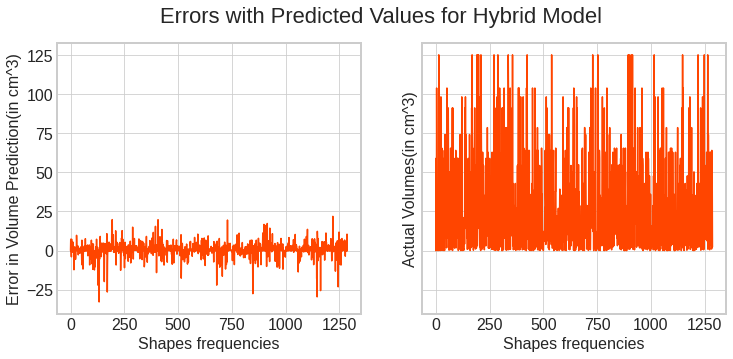

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5),sharey=True)
fig.suptitle('Errors with Predicted Values for Hybrid Model')
ax1.plot(y_test/1000-y_npred/1000,color='#FF4500')
ax1.set_xlabel("Shapes frequencies")
ax1.set_ylabel("Error in Volume Prediction(in cm^3)")

ax2.plot(y_test/1000,color='#FF4500')
ax2.set_xlabel("Shapes frequencies")
ax2.set_ylabel("Actual Volumes(in cm^3)")

### **Model-3 - Using Images through 2 different inputs and distances as inputs** 

**I tried this model to solve the problem of categorizing the shapes and it should enhance the predictions.<br>**

**If the previous model could not categorize the shapes well, this should do it more efficiently, because in this model, I have one branch of input which has the outputs with softmax activation at the end before merging it to the model. So, it should take care of problems where the volumes come wrong due to wrong prediction of shapes.**

In [ ]:
visible1 = Input(shape=(142,142,1))
conv11 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(visible1)
conv12 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv11)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv12)
conv13 = Conv2D(64, (3,3), activation='relu')(pool11)
drop11 = Dropout(0.2)(conv13)
conv14 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(drop11)
conv15 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv14)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv15)
conv16 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(pool12)
conv17 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv16)
pool13 = MaxPooling2D(pool_size=(2, 2))(conv17)
flat1 = Flatten()(pool13)
dense11 = Dense(128, activation = 'relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(flat1)
dense12 = Dense(128, activation = 'relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(dense11)
dense13 = Dense(64, activation = 'relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(dense12)
dense14 = Dense(3, activation = 'softmax',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(dense13)

# second part taking the distances from the cameras as input
visible2 = Input(shape = (4))
dense21 = Dense(64, activation = 'relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(visible2)
dense22 = Dense(64, activation = 'relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(dense21)

visible3 = Input(shape=(142,142,1))
conv31 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(visible3)
conv32 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv31)
pool31 = MaxPooling2D(pool_size=(2, 2))(conv32)
conv33 = Conv2D(64, (3,3), activation='relu')(pool31)
drop31 = Dropout(0.2)(conv33)
conv34 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(drop31)
conv35 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv34)
pool32 = MaxPooling2D(pool_size=(2, 2))(conv35)
conv36 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(pool32)
conv37 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001))(conv36)
pool33 = MaxPooling2D(pool_size=(2, 2))(conv37)
flat3 = Flatten()(pool33)
# concatenating both outputs
merge = concatenate([flat3,dense14, dense22])

# making the dense layers with both these models
hidden1 = Dense(100, activation='relu')(merge)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(1)(hidden2)
model_concat_fin = Model(inputs=[visible1, visible2, visible3], outputs=output)

In [ ]:
model_concat_fin.compile(loss='mse', optimizer ="Adam")

In [ ]:
print(model_concat_fin.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 142, 142, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 142, 142, 64  640         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_48 (Conv2D)             (None, 142, 142, 64  36928       ['conv2d_47[0][0]']              
                                )                                                           

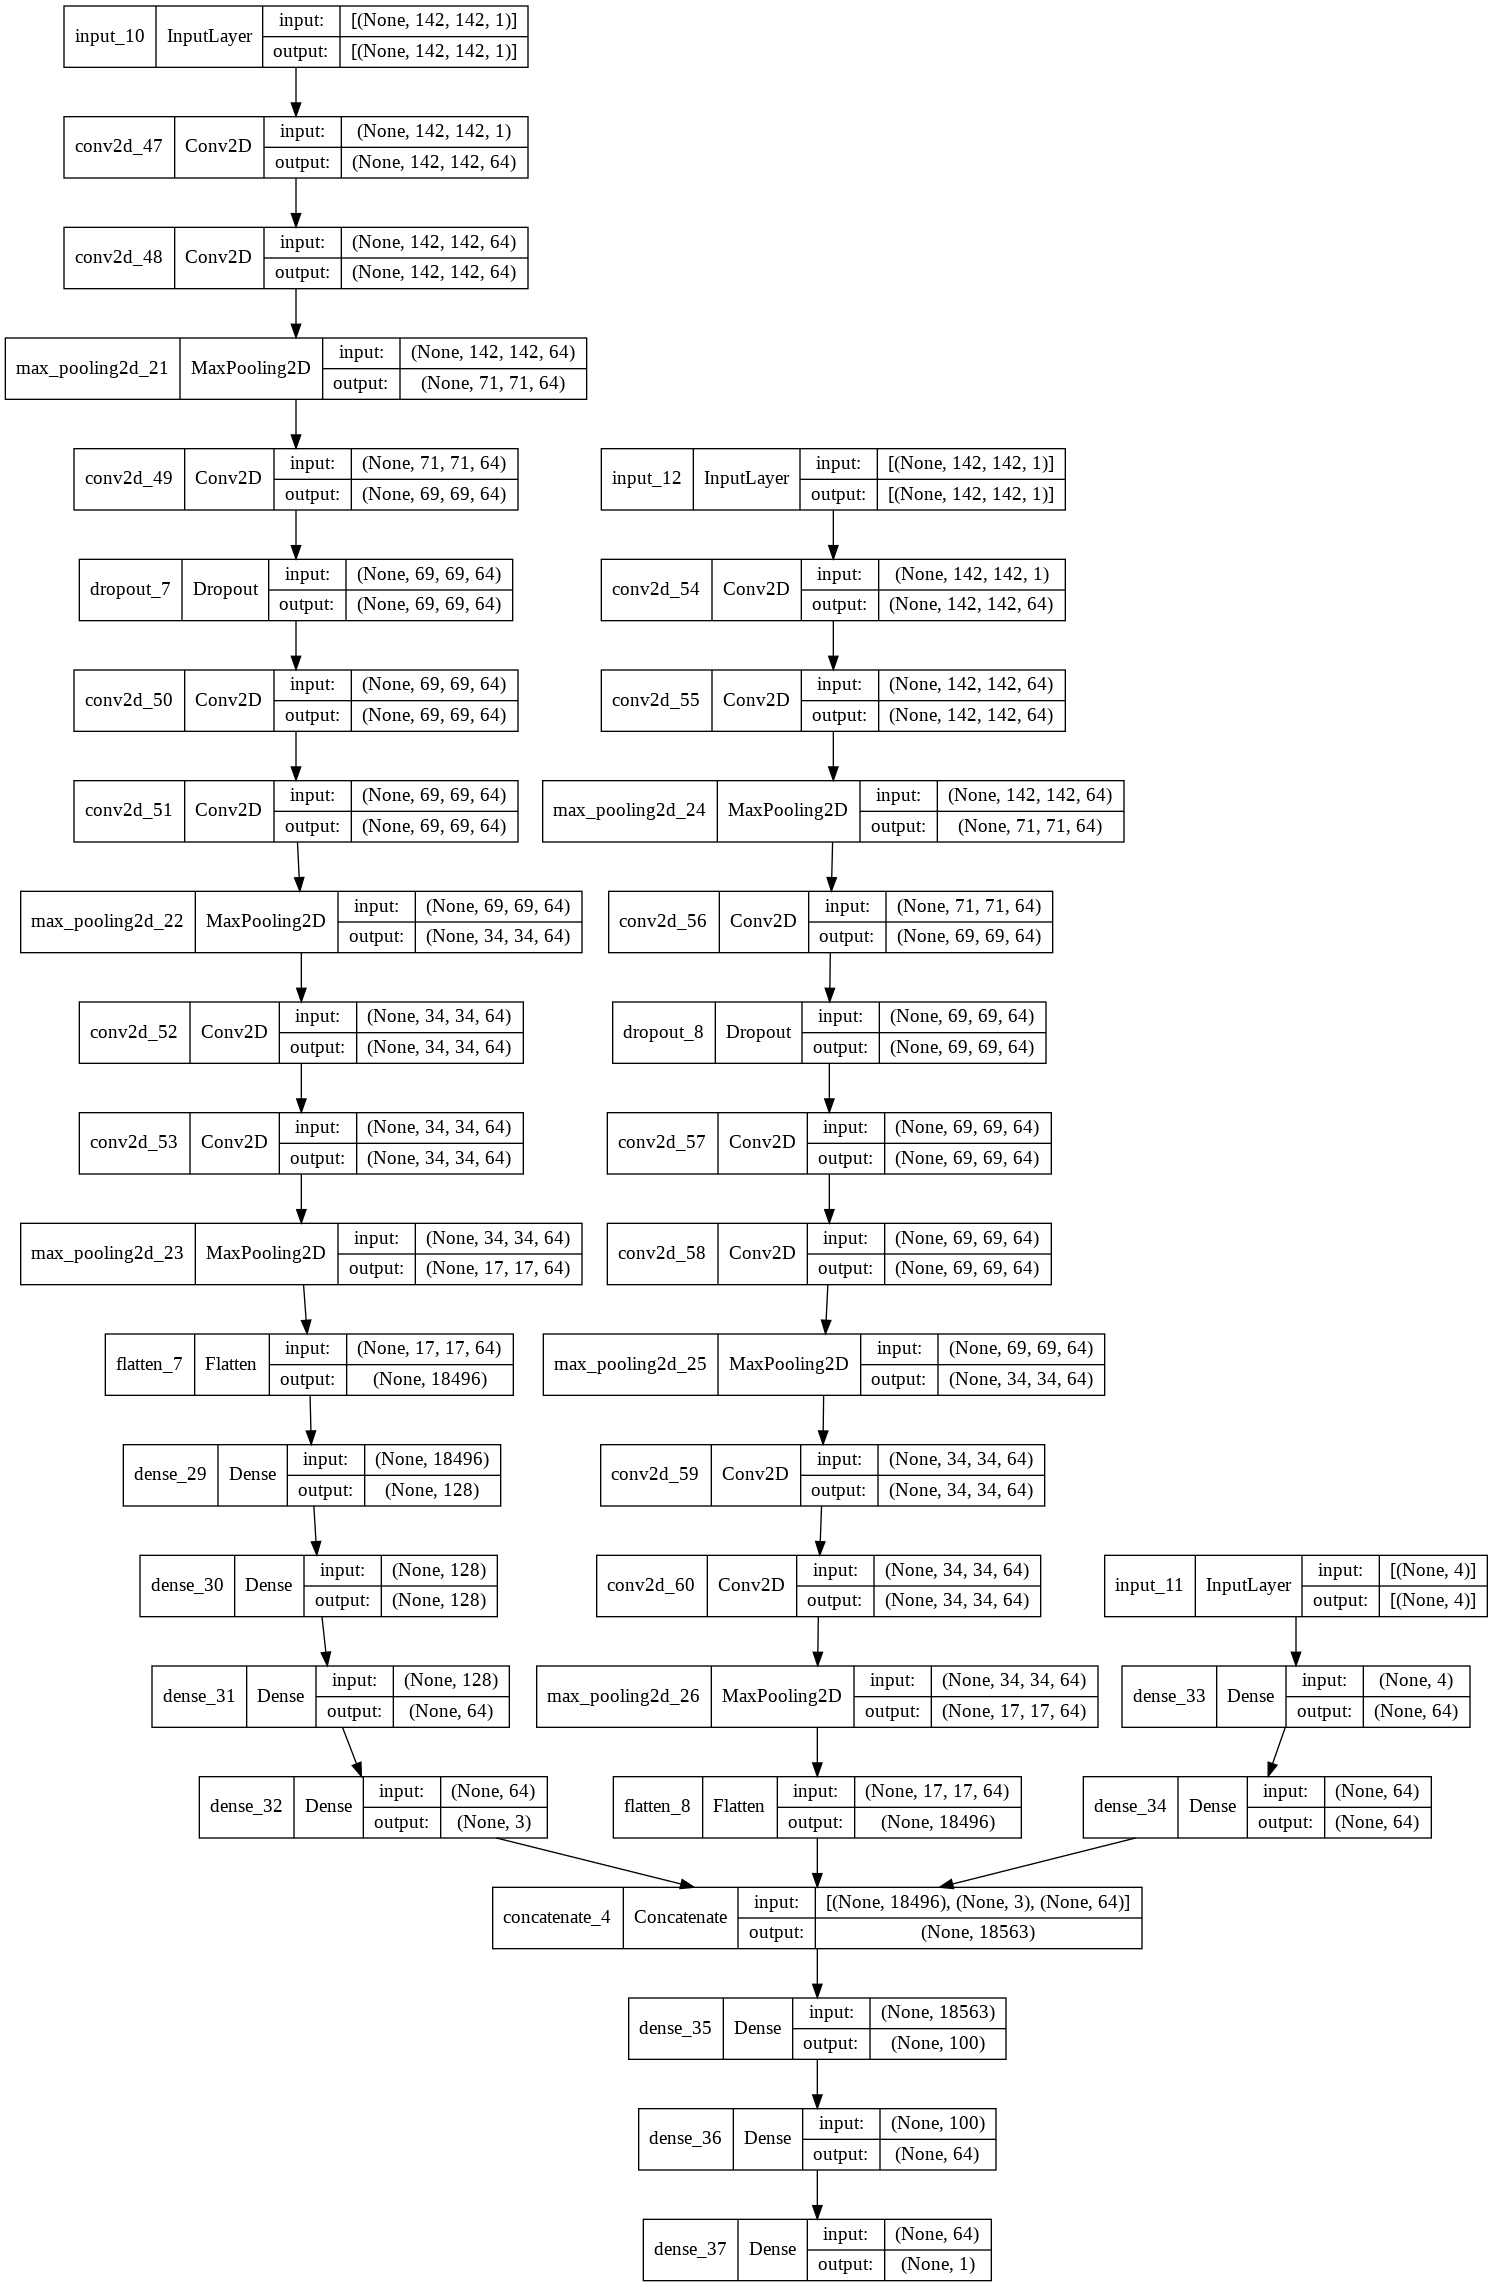

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_concat_fin, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_3_history = model_concat_fin.fit(x = [x_train_norm,x_ntrain, x_train_norm],y = y_train, epochs=50, batch_size=64, validation_data=([x_test_norm, x_ntest, x_test_norm], y_test), verbose=1, callbacks = [callback])

Epoch 1/50
81/81 [==============================] - 58s 686ms/step - loss: 420595264.0000 - val_loss: 229132272.0000
Epoch 2/50
81/81 [==============================] - 54s 672ms/step - loss: 211216032.0000 - val_loss: 240393472.0000
Epoch 3/50
81/81 [==============================] - 54s 671ms/step - loss: 182521952.0000 - val_loss: 153286704.0000
Epoch 4/50
81/81 [==============================] - 54s 671ms/step - loss: 103057336.0000 - val_loss: 72490040.0000
Epoch 5/50
81/81 [==============================] - 54s 671ms/step - loss: 49543888.0000 - val_loss: 49798108.0000
Epoch 6/50
81/81 [==============================] - 54s 671ms/step - loss: 33550798.0000 - val_loss: 49066276.0000
Epoch 7/50
81/81 [==============================] - 54s 671ms/step - loss: 29694558.0000 - val_loss: 34143500.0000
Epoch 8/50
81/81 [==============================] - 54s 673ms/step - loss: 34827620.0000 - val_loss: 37378520.0000
Epoch 9/50
81/81 [==============================] - 54s 670ms/step - loss

In [ ]:
model_concat_fin.save_weights('/content/drive/MyDrive/project-2/model_concat_fin_weights.npy')
# model_concat_fin.load_weights('/content/drive/MyDrive/project-2/model_concat_fin_weights.npy')

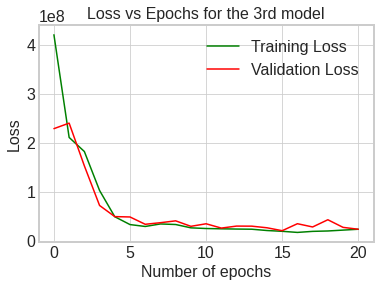

In [ ]:
plt.plot(model_3_history.history['loss'], color='g', label='Training Loss')
plt.plot(model_3_history.history['val_loss'], color='r', label='Validation Loss')
plt.title("Loss vs Epochs for the 3rd model")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
y_nn_pred = model_concat_fin.predict(x = [x_test_norm, x_ntest, x_test_norm])

In [ ]:
from sklearn.metrics import r2_score
print("The R2 score for the 3rd model is {:.2f}".format(r2_score(y_test, y_nn_pred)))

The R2 score for the 3rd model is 0.98


In [ ]:
y_nn_pred = y_nn_pred.reshape(-1,1)

Text(0, 0.5, 'Actual Volumes(in cm^3)')

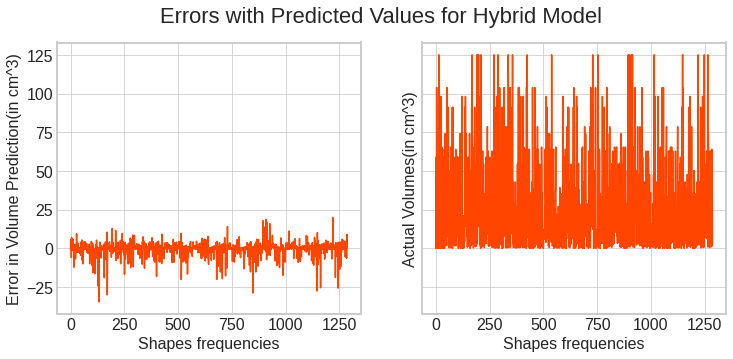

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5),sharey=True)
fig.suptitle('Errors with Predicted Values for Hybrid Model')
ax1.plot(y_test/1000-y_nn_pred/1000,color='#FF4500')
ax1.set_xlabel("Shapes frequencies")
ax1.set_ylabel("Error in Volume Prediction(in cm^3)")

ax2.plot(y_test/1000,color='#FF4500')
ax2.set_xlabel("Shapes frequencies")
ax2.set_ylabel("Actual Volumes(in cm^3)")

## **Analysis**

In [ ]:
print("The R2 score for the CNN model is {:.2f}".format(r2_score(y_test, y_pred)))
print("The R2 score for the Hybrid model is {:.2f}".format(r2_score(y_test, y_npred)))
print("The R2 score for the 3rd model is {:.2f}".format(r2_score(y_test, y_nn_pred)))

The R2 score for the CNN model is 0.80
The R2 score for the Hybrid model is 0.98
The R2 score for the 3rd model is 0.98


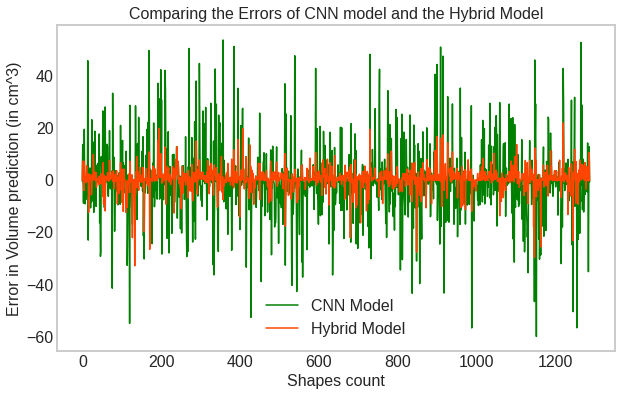

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test/1000-y_pred/1000, color='g', label='CNN Model')
plt.plot(y_test/1000-y_npred/1000, color='#FF4500', label='Hybrid Model')
plt.title("Comparing the Errors of CNN model and the Hybrid Model")
plt.xlabel('Shapes count')
plt.ylabel("Error in Volume prediction (in cm^3)")
plt.legend()
plt.grid(False)

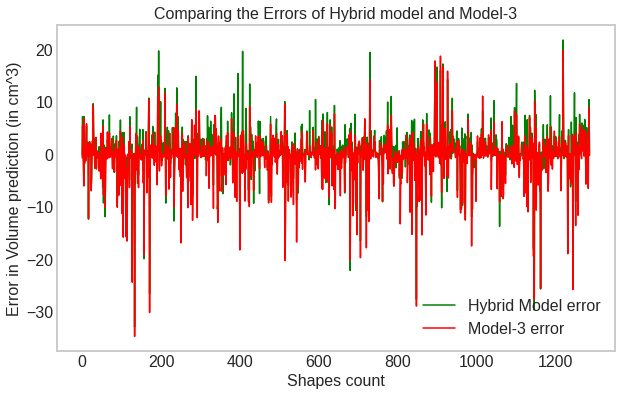

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test/1000-y_npred/1000, color='g', label='Hybrid Model error')
plt.plot(y_test/1000-y_nn_pred/1000, color='r', label='Model-3 error')
plt.title("Comparing the Errors of Hybrid model and Model-3")
plt.xlabel('Shapes count')
plt.ylabel("Error in Volume prediction (in cm^3)")
plt.legend()
plt.grid(False)

**From the above plots, we can easily see that the basic CNN model performs very badly as compared to the Hybrid model and the 3rd model. The hybrid and 3rd model have same R2 scores and and from the error analysis also, we can see that their errors are comparable.**

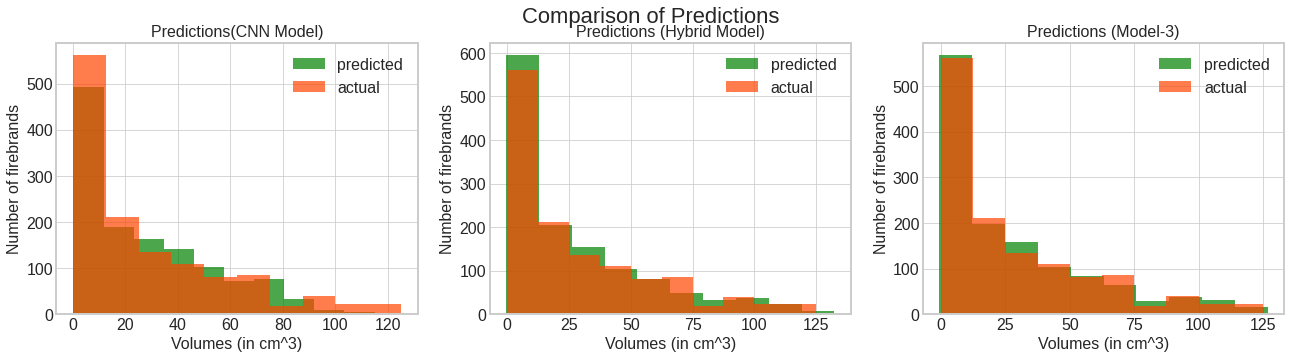

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle('Comparison of Predictions')

ax1.hist(y_pred/1000,alpha = 0.7, lw=3, color= 'g', bins = 10, label='predicted')
ax1.hist(y_test/1000,alpha = 0.7, lw=3, color= '#FF4500', bins = 10, label='actual')
ax1.set_title("Predictions(CNN Model)")
ax1.set_xlabel("Volumes (in cm^3)")
ax1.set_ylabel("Number of firebrands")
ax1.legend()

ax2.hist(y_npred/1000,alpha = 0.7, lw=3, color= 'g', bins = 10, label='predicted')
ax2.hist(y_test/1000,alpha = 0.7, lw=3, color= '#FF4500', bins = 10, label='actual')
ax2.set_title("Predictions (Hybrid Model)")
ax2.set_xlabel("Volumes (in cm^3)")
ax2.set_ylabel("Number of firebrands")
ax2.legend()

ax3.hist(y_nn_pred/1000,alpha = 0.7, lw=3, color= 'g', bins = 10, label='predicted')
ax3.hist(y_test/1000,alpha = 0.7, lw=3, color= '#FF4500', bins = 10, label='actual')
ax3.set_title("Predictions (Model-3)")
ax3.set_xlabel("Volumes (in cm^3)")
ax3.set_ylabel("Number of firebrands")
ax3.legend()

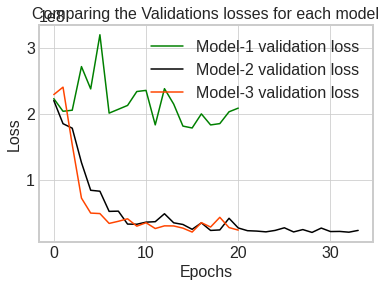

In [ ]:
plt.plot(model_1_history.history['val_loss'], color='g', label='Model-1 validation loss')
plt.plot(model_2_history.history['val_loss'], color='#000000', label='Model-2 validation loss')
plt.plot(model_3_history.history['val_loss'], color='#FF4500', label='Model-3 validation loss')
plt.title("Comparing the Validations losses for each model")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

**From all the interpretations above, the 2nd model and the 3rd model seem to be working great. The validation loss decreases consistently, there are no abrupt peaks in loss. The R2 score is almost same.**